In [41]:
from typing import *
import pandas as pd
import libcst as cst
import re
import networkx as nx

In [42]:
example_code = open('example.py', 'r').read()
print(example_code)

class A:

    def __init__(self):
        self._k = 2
        pass

    def _a(self, number):
        if number == 2:
            pass

    def _c(self):
        self._a(2)
        self.b()

    def b(self):
        pass

    def d(self):
        self.b()
        func = self._a
        func(5)

    B = 0



In [43]:
example_code_cst = cst.parse_module(example_code)
# example_code_cst

In [44]:
class_def = example_code_cst.body[0]
# example_code_cst.body[0] = class_def.with_changes(whitespace_before_colon=cst.SimpleWhitespace(value=' '))

In [45]:
class_nodes_iter = class_def.body.body
# class_nodes_iter

In [46]:
class_node = class_nodes_iter[4]
class_node

FunctionDef(
    name=Name(
        value='d',
        lpar=[],
        rpar=[],
    ),
    params=Parameters(
        params=[
            Param(
                name=Name(
                    value='self',
                    lpar=[],
                    rpar=[],
                ),
                annotation=None,
                equal=MaybeSentinel.DEFAULT,
                default=None,
                comma=MaybeSentinel.DEFAULT,
                star='',
                whitespace_after_star=SimpleWhitespace(
                    value='',
                ),
                whitespace_after_param=SimpleWhitespace(
                    value='',
                ),
            ),
        ],
        star_arg=MaybeSentinel.DEFAULT,
        kwonly_params=[],
        star_kwarg=None,
        posonly_params=[],
        posonly_ind=MaybeSentinel.DEFAULT,
    ),
    body=IndentedBlock(
        body=[
            SimpleStatementLine(
                body=[
                    Expr(
           

In [ ]:
method_nodes_iter = class_node.body.body
method_nodes_iter

In [ ]:
method_node = method_nodes_iter[0]
method_node

In [ ]:
method_node.body

In [ ]:
class_def.body.body[2].body.body[0].body[0].value.func.attr

In [ ]:
hasattr(class_def, 'body')

In [ ]:
class_def.body.header, class_def.body.footer, class_def.body.indent

In [ ]:
print(example_code_cst.code)

In [ ]:
example_code_cst.body[0].body

In [ ]:
def sort_functions(functions_list: list):
    df = pd.DataFrame([(b.name.value, b) for b in functions_list], columns=['func_name', 'body'])
    df['is_magic'] = df['func_name'].str.startswith('__') & df['func_name'].str.endswith('__')
    df['is_public'] = ~df['func_name'].apply(lambda x: re.search('^_[a-zA-Z]', x) is not None)
    df_2 = df.sort_values(['is_magic', 'is_public'], ascending=False)
    sorted_functions_list = df_2['body'].tolist()
    return sorted_functions_list

In [ ]:
class TypingTransformer(cst.CSTTransformer):
    def visit_ClassDef(self, node: cst.IndentedBlock) -> Optional[bool]:
        pass
        
    def leave_ClassDef(self, original_node: cst.ClassDef, updated_node: cst.ClassDef) -> cst.CSTNode:        
        if isinstance(original_node, cst.ClassDef):
            print('changing')
            new_body = updated_node.body.with_changes(body=sort_functions(updated_node.body.body))
            updated_node_2 = updated_node.with_changes(body=new_body)
            return updated_node_2
        return updated_node

In [ ]:
transformer = TypingTransformer()
modified_tree = example_code_cst.visit(transformer)
print(example_code_cst.code)
print(modified_tree.code)

In [ ]:
example_code_cst.body[0].body

In [ ]:
re.search('^__.*__$', '__sdf__')

In [27]:
class CallGraphCollector(cst.CSTVisitor):
    def __init__(self):
        self._used_methods_list : List[str] = []

    def visit_Attribute(self, node: cst.Attribute):
        if node.value.value == 'self':
            self._used_methods_list.append(node.attr.value)
            print(node.attr.value)
    
    def get_used_methods_list(self):
        return self._used_methods_list

In [28]:
collector = CallGraphCollector()
l = class_node.visit(collector)

b
_a


In [29]:
collector.get_used_methods_list()

['b', '_a']

In [47]:
call_graph = []
for node in class_nodes_iter:
    if isinstance(node, cst.FunctionDef):
        collector = CallGraphCollector()
        node.visit(collector)
        used_methods_list = collector.get_used_methods_list()
        call_graph.append((node.name.value, node, used_methods_list))
# call_graph

_k
_a
b
b
_a


In [55]:
a = pd.DataFrame(call_graph, columns=['func_name', 'node', 'used_objects'])
a

,func_name,node,used_objects
0,__init__,FunctionDef(\n name=Name(\n value='_...,[_k]
1,_a,FunctionDef(\n name=Name(\n value='_...,[]
2,_c,FunctionDef(\n name=Name(\n value='_...,"[_a, b]"
3,b,FunctionDef(\n name=Name(\n value='b...,[]
4,d,FunctionDef(\n name=Name(\n value='d...,"[b, _a]"


In [56]:
b = a.func_name.tolist()
b

['__init__', '_a', '_c', 'b', 'd']

In [69]:
a['used_functions'] = a['used_objects'].apply(lambda x: list(set(x).intersection(b)))

In [70]:
a

,func_name,node,used_objects,used_functions
0,__init__,FunctionDef(\n name=Name(\n value='_...,[_k],[]
1,_a,FunctionDef(\n name=Name(\n value='_...,[],[]
2,_c,FunctionDef(\n name=Name(\n value='_...,"[_a, b]","[_a, b]"
3,b,FunctionDef(\n name=Name(\n value='b...,[],[]
4,d,FunctionDef(\n name=Name(\n value='d...,"[b, _a]","[_a, b]"


In [93]:
nx.__version__

'2.4'

In [80]:
G

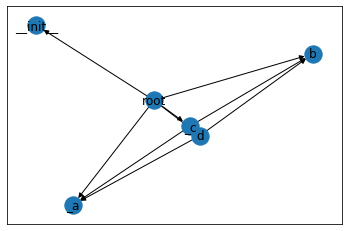

In [81]:
nx.draw_networkx(G)

In [82]:
max(nx.all_simple_paths(G, ROOT, 'b'), key=lambda x: len(x))

['root', '_c', 'b']

In [85]:
a['distance'] = a['func_name'].apply(lambda y: len(max(nx.all_simple_paths(G, ROOT, y), key=lambda x: len(x))) - 1)

In [87]:
a

,func_name,node,used_objects,used_functions,distance
0,__init__,FunctionDef(\n name=Name(\n value='_...,[_k],[],1
1,_a,FunctionDef(\n name=Name(\n value='_...,[],[],2
2,_c,FunctionDef(\n name=Name(\n value='_...,"[_a, b]","[_a, b]",1
3,b,FunctionDef(\n name=Name(\n value='b...,[],[],2
4,d,FunctionDef(\n name=Name(\n value='d...,"[b, _a]","[_a, b]",1


In [ ]:
class CallGraphCollector(cst.CSTVisitor):
    def __init__(self):
        self._used_methods_list : List[str] = []

    def visit_Attribute(self, node: cst.Attribute):
        if node.value.value == 'self':
            self._used_methods_list.append(node.attr.value)
            print(node.attr.value)
    
    def get_used_methods_list(self):
        return self._used_methods_list

In [91]:
collector = CallGraphCollector()
l = class_node.visit(collector)

call_graph = []
for node in class_nodes_iter:
    if isinstance(node, cst.FunctionDef):
        collector = CallGraphCollector()
        node.visit(collector)
        used_methods_list = collector.get_used_methods_list()
        call_graph.append((node.name.value, node, used_methods_list))
        
a = pd.DataFrame(call_graph, columns=['func_name', 'node', 'used_objects'])
a['used_functions'] = a['used_objects'].apply(lambda x: list(set(x).intersection(b)))

G = nx.DiGraph()
ROOT = 'root'
G.add_node(ROOT)

for index, row in a.iterrows():
    print(row['func_name'])
    G.add_node(row['func_name'])
    
for index, row in a.iterrows():
    G.add_edge(ROOT, row['func_name'])
    for called_func in row['used_functions']:
        G.add_edge(row['func_name'], called_func)
        
a['distance'] = a['func_name'].apply(lambda y: len(max(nx.all_simple_paths(G, ROOT, y), key=lambda x: len(x))) - 1)

b
_a
_k
_a
b
b
_a
__init__
_a
_c
b
d


In [92]:
a

,func_name,node,used_objects,used_functions,distance
0,__init__,FunctionDef(\n name=Name(\n value='_...,[_k],[],1
1,_a,FunctionDef(\n name=Name(\n value='_...,[],[],2
2,_c,FunctionDef(\n name=Name(\n value='_...,"[_a, b]","[_a, b]",1
3,b,FunctionDef(\n name=Name(\n value='b...,[],[],2
4,d,FunctionDef(\n name=Name(\n value='d...,"[b, _a]","[_a, b]",1
